# 3D crossing-the-line detection boxes from 2D video using Yolo/Segment-Anything-2/Monocular depth detection

In [1]:
%%capture pip
!pip install ultralytics==8.2.71
!pip install torch==2.4.0
!pip install torchvision==0.19.0
!pip install torchaudio==2.4.0
#!pip install git+https://github.com/facebookresearch/segment-anything-2.git
!pip install matplotlib==3.9.1
!pip install pillow
!pip install opencv-python-headless==4.10.0.84;

In [2]:
import os
HOME = os.getcwd()
%mkdir -p {HOME}/videos
%mkdir -p {HOME}/checkpoints

In [3]:
%%capture git
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

In [4]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import torch
import numpy as np
import cv2
from ultralytics import YOLO
from sam2.utils.misc import get_sdpa_settings
from sam2.build_sam import build_sam2_video_predictor
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [6]:
OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()
print(f"{OLD_GPU}, {USE_FLASH_ATTN}, {MATH_KERNEL_ON}")

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

#sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
predictor = build_sam2_video_predictor(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

False, True, False


In [19]:
#mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

## Load the data

Create a folder called `videos/001` and place your mp4 video, renaming it `input_video.mp4`, in this folder.
Run the command

```
ffmpeg -i input_video.mp4 -q:v 2 %04d.jpg
```

in that folder to extract frames as jpg, then run the next cell

In [7]:
# Define directories
video_dir = f"{HOME}/videos/"
processed_dir = f"{HOME}/processed"

# Create the processed directory if it doesn't exist
os.makedirs(video_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

In [28]:
# %%capture ffmpeg
# %%!cd {HOME}/videos && ffmpeg -i input_video.mp4 -q:v 2 %04d.png

In [151]:

def convert_mp4_to_jpg(mp4_file, output_folder, one_frame_per_second=False):
    """Converts an mp4 file to high-quality jpg files."""
    os.makedirs(output_folder, exist_ok=True)
    video = cv2.VideoCapture(mp4_file)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    saved_frame_count = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break

        if one_frame_per_second:
            # Calculate the frame number to save
            if frame_count % int(fps) == 0:
                output_file = os.path.join(output_folder, f"{saved_frame_count:04d}.jpg")
                success = cv2.imwrite(output_file, frame, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
                if success:
                    pass
                    #print(f"Frame {saved_frame_count} written successfully")
                else:
                    print(f"Failed to write frame {saved_frame_count}")
                saved_frame_count += 1
        else:
            output_file = os.path.join(output_folder, f"{frame_count:04d}.jpg")
            success = cv2.imwrite(output_file, frame, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
            if success:
                pass
                #print(f"Frame {frame_count} written successfully")
            else:
                print(f"Failed to write frame {frame_count}")

        frame_count += 1

    video.release()

mp4_file_path = f"{HOME}/videos/input_video.mp4"  # Replace with your mp4 file path
output_folder_path = f"{HOME}/processed"
convert_mp4_to_jpg(mp4_file_path, output_folder_path, one_frame_per_second=True)

In [152]:
# def convert_mp4_to_jpg(mp4_file, output_folder):
#     """Converts an mp4 file to high-quality jpg files."""
#     os.makedirs(output_folder, exist_ok=True)
#     video = cv2.VideoCapture(mp4_file)
#     frame_count = 0
#     while True:
#         ret, frame = video.read()
#         if not ret:
#             break
#         output_file = os.path.join(output_folder, f"{frame_count:04d}.jpg")
#         success = cv2.imwrite(output_file, frame, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
#         if success:
#             pass
#             #print(f"Frame {frame_count} written successfully")
#         else:
#             print(f"Failed to write frame {frame_count}")
#         frame_count += 1
#     video.release()


# mp4_file_path = f"{HOME}/videos/input_video.mp4"  # Replace with your mp4 file path
# output_folder_path = f"{HOME}/processed"
# convert_mp4_to_jpg(mp4_file_path, output_folder_path)


In [153]:
# Scan all the frame names in the processed directory
processed_frame_names = [
    p for p in os.listdir(output_folder_path )
    if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
]

# Sort frame names by extracting the numerical part of the filenames
processed_frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]))

## First pass
* detect people and show bounding boxes for all those whose bounding box falls within the designated red zone

In [173]:
# which frame to detect on
frame_idx = 1

/content/processed/0001.jpg
File exists
Image loaded successfully with OpenCV


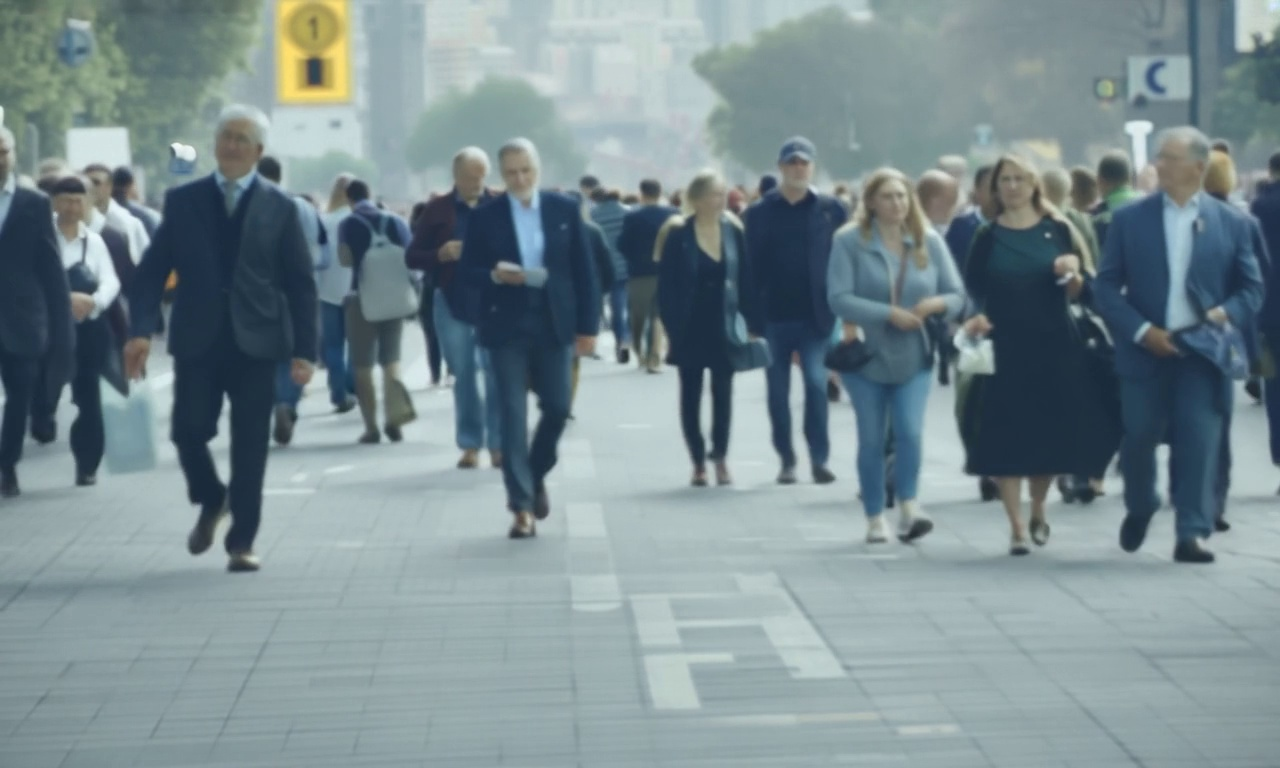

Valid JPEG image


In [174]:
IS_COLAB = True

if IS_COLAB:
    from google.colab.patches import cv2_imshow


image_path = os.path.join(output_folder_path, processed_frame_names[frame_idx])
print(image_path)

if os.path.exists(image_path):
    print("File exists")
else:
    print("File does not exist")

image = cv2.imread(image_path)
if image is not None:
    print("Image loaded successfully with OpenCV")
    cv2_imshow(image)  # Display image using OpenCV
else:
    print("Failed to load image with OpenCV")

# Check if the file is a valid JPEG image
try:
    with open(image_path, 'rb') as f:
        f.seek(-2, 2)
        if f.read() == b'\xff\xd9':
            print("Valid JPEG image")
        else:
            print("Invalid JPEG image")
except Exception as e:
    print(f"Error reading file: {e}")

try:
    image = Image.open(image_path)
    image.show()  # Display the image
except Exception as e:
    print(f"Error opening image with PIL: {e}")

In [175]:
# Check first few bytes of the image file to verify content
# with open(resaved_image_path, 'rb') as f:
#     header = f.read(10)
#     print(f"Image header: {header}")

In [176]:
# Define and add the rectangle patch with transparency
rect_x = 380
rect_y = 380
rect_width = 330
rect_height = 200
# Define a function to plot the figure and rectangle patch
def plot_with_rect(ax, image, rect_x, rect_y, rect_width, rect_height):
    # Display the original image
    ax.imshow(image)

    # Create and add the rectangle patch
    rect = patches.Rectangle(
        (rect_x, rect_y), rect_width, rect_height,
        linewidth=1, edgecolor='r', facecolor='red', alpha=0.3
    )
    ax.add_patch(rect)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 384x640 14 persons, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


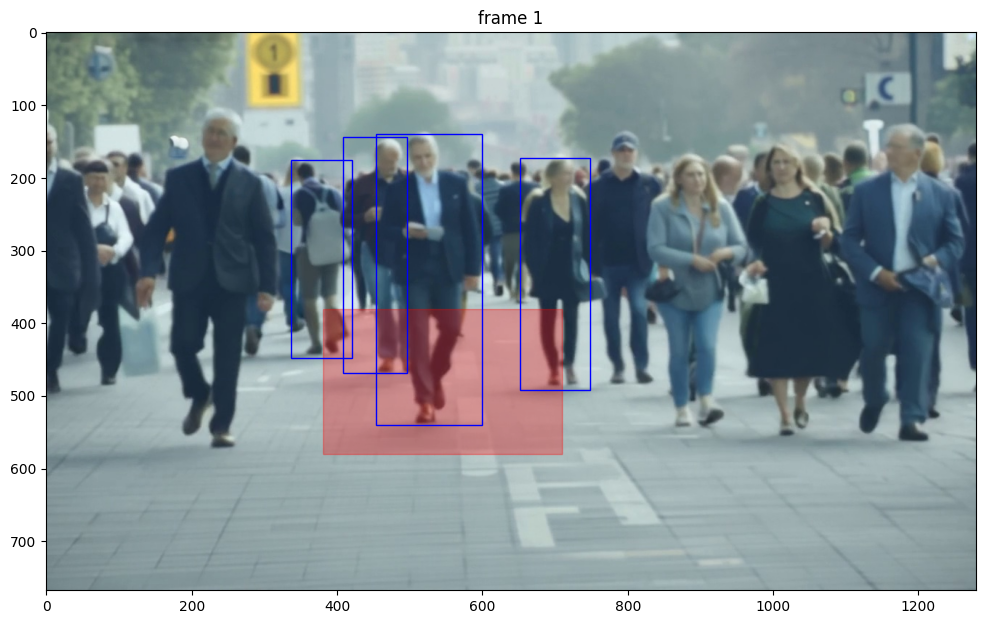

In [177]:
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.title(f"frame {frame_idx}")
plt.imshow(image)


# Add the patch to the Axes
plot_with_rect(ax, image, rect_x, rect_y, rect_width, rect_height)


# Load YOLO model
yolo_model = YOLO('yolov5s.pt')  # Use the appropriate YOLOv5 model

# Load the image with OpenCV
cv2_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Detect objects in the image
results = yolo_model(cv2_image)

# Filter detections to find people
detected_people_centers = []
filtered_boxes = []
for result in results[0].boxes.data:  # Accessing the first result and its boxes
    x1, y1, x2, y2, conf, cls = result.cpu().numpy()  # Transfer to CPU and convert to numpy array
    if int(cls) == 0:  # Class 0 is 'person' in COCO
        if (x1 < rect_x + rect_width and x2 > rect_x and y1 < rect_y + rect_height and y2 > rect_y):
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            detected_people_centers.append([center_x, center_y])
            filtered_boxes.append((x1, y1, x2, y2))
            # Draw bounding box
            plt.gca().add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='b', facecolor='none'))

# Convert detected people centers to a numpy array
points = np.array(detected_people_centers)
labels = np.ones(len(points), dtype=np.int32)

# Display the updated plot with bounding boxes
plt.show()

In [178]:
# # Load SAM2 model and initialize the predictor
# checkpoint = "/content/segment-anything-2/checkpoints/sam2_hiera_large.pt"
# model_cfg = "/content/segment-anything-2/sam2_configs/sam2_hiera_l.yaml"
# predictor = build_sam2_video_predictor(f"/{model_cfg}", checkpoint)

In [179]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [180]:
def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [181]:
# Define the function to generate more points within the bounding boxes
# def generate_points_within_box(x1, y1, x2, y2, num_points=10):
#     points = []
#     for _ in range(num_points):
#         px = np.random.uniform(x1, x2)
#         py = np.random.uniform(y1, y2)
#         points.append([px, py])
#     return points

In [187]:
def find_center_point(x1, y1, x2, y2):
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    return [(cx, cy)]

def add_points_around_bbox(x1, y1, x2, y2, distance):
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    return [(cx, cy), (cx, cy + distance), (cx, cy - 3*distance)]


frame loading (JPEG): 100%|██████████| 11/11 [00:00<00:00, 28.19it/s]


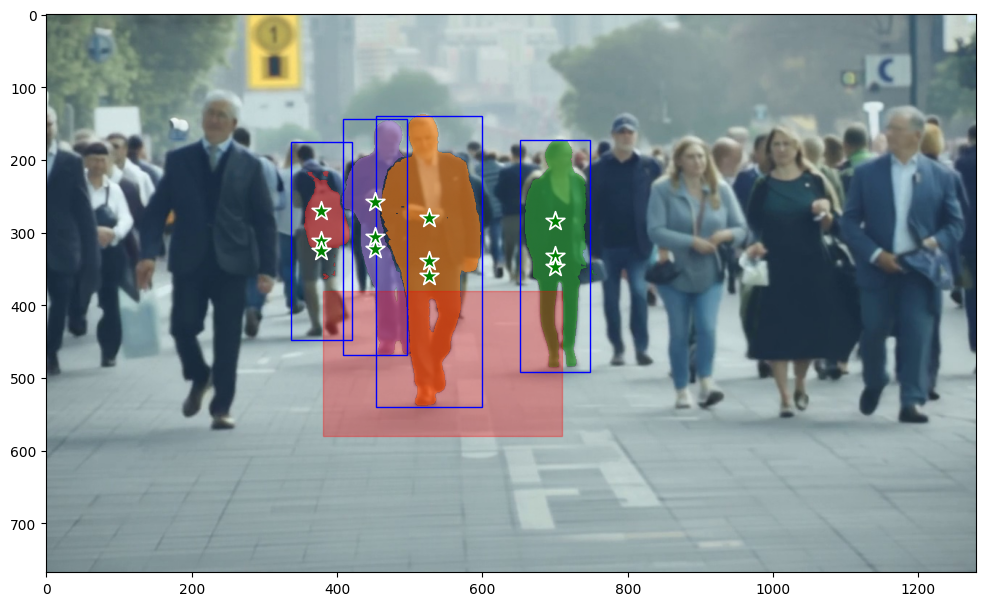

In [188]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    inference_state = predictor.init_state(video_path=output_folder_path)

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    # Display the original image
    ax.imshow(image)

    # Add the patch to the Axes
    plot_with_rect(ax, image, rect_x, rect_y, rect_width, rect_height)

    # Track initial masks for each detected person
    initial_points = {}
    initial_masks = {}

    for ann_obj_id, (x1, y1, x2, y2) in enumerate(filtered_boxes, start=1):
        # Generate points within the bounding box and additional points above and below
        bbox_height = y2 - y1
        additional_distance = 0.05 * bbox_height
        extended_points = add_points_around_bbox(x1, y1, x2, y2, additional_distance)
        extended_points = np.array(extended_points)
        extended_labels = np.ones(len(extended_points), dtype=np.int32)

        # Store the initial points for later use
        initial_points[ann_obj_id] = (extended_points, extended_labels)

        # Add new points for the first frame (using the extended points)
        if extended_points.size > 0:
            predictor.reset_state(inference_state)
            _, out_obj_ids, out_mask_logits = predictor.add_new_points(
                inference_state=inference_state,
                frame_idx=frame_idx,
                obj_id=ann_obj_id,
                points=extended_points,
                labels=extended_labels,
            )

            initial_masks[ann_obj_id] = (out_mask_logits[0] > 0.0).cpu().numpy()

            # Draw the YOLO bounding box
            ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='b', facecolor='none'))

            # Overlay the SAM2 mask
            show_mask(initial_masks[ann_obj_id], ax, obj_id=ann_obj_id)
            show_points(extended_points, extended_labels, ax)

    # Show the final plot with the highlighted people
    plt.show()

In [189]:
# Initialize a dictionary to store masks per frame per person
video_segments = {}

# Run propagation for each detected person individually
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    for ann_obj_id, (points, labels) in initial_points.items():
        # Reset the state for the current object
        inference_state = predictor.init_state(video_path=output_folder_path)
        predictor.reset_state(inference_state)
        predictor.add_new_points(
            inference_state=inference_state,
            frame_idx=frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
        )

        # Propagate the masks for the current object throughout the video
        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
            if out_frame_idx not in video_segments:
                video_segments[out_frame_idx] = {}
            if ann_obj_id in out_obj_ids:
                video_segments[out_frame_idx][ann_obj_id] = (out_mask_logits[out_obj_ids.index(ann_obj_id)] > 0.0).cpu().numpy()


propagate in video: 100%|██████████| 10/10 [00:00<00:00, 13.12it/s]


In [190]:
# Define the output directory for the frames
output_dir = os.path.join(f"{HOME}", 'output_frames')
os.makedirs(output_dir, exist_ok=True)
# Render the segmentation results every x frame and save as PNG
vis_frame_stride = 1
plt.close("all")
frame_paths = []
for out_frame_idx in range(0, len(processed_frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(processed_dir, processed_frame_names[out_frame_idx])))
    if out_frame_idx in video_segments:
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    frame_path = os.path.join(output_dir, f"frame_{out_frame_idx:04d}.png")
    plt.savefig(frame_path)
    frame_paths.append(frame_path)
    plt.close()


In [191]:
from moviepy.editor import VideoFileClip, ImageSequenceClip

# Path to the input video
input_video_path = os.path.join(f"{HOME}", 'videos', 'input_video.mp4')

# Detect the frame rate of the input video
video_clip = VideoFileClip(input_video_path)
frame_rate = video_clip.fps

# Create a video from the saved frames using moviepy
video_output_path = os.path.join(f"{HOME}", 'videos', 'output_video.mp4')
clip = ImageSequenceClip(frame_paths, fps=frame_rate)
clip.write_videofile(video_output_path, codec='libx264')

Moviepy - Building video /content/videos/output_video.mp4.
Moviepy - Writing video /content/videos/output_video.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/output_video.mp4
